In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [55]:
from tensorflow.data import Dataset
from random import randint

seq_len = 32
batch_size = 64

df = pd.read_csv("../data/data_iq.csv", names=["SNR", "mode", "idk", "label", *range(0, seq_len + 1)])

# last column is empty, drop it
del df[df.columns[-1]]

# convert labels to numbers
labels = {label : i for i, label in enumerate(df["label"].unique())}
for label, i in labels.items():
    df["label"].replace(label, i, inplace=True)

# group dataframes by SNR
ds_per_snr = {}
for snr in df["SNR"].unique():
    # get only rows with current SNR
    df_snr = df[df["SNR"] == snr]
    # reshape data to give I, Q their own dimension
    data = np.reshape(df_snr.iloc[:, -seq_len:], (-1, 2, seq_len))
    # create dataset from IQ data shape=(64, 2, 32)
    ds_data = Dataset.from_tensor_slices(data)
    # create dataset for labels shape=(64)
    ds_labels = Dataset.from_tensor_slices(df_snr["label"].iloc[::2])
    # pair data with label
    ds_per_snr[snr] = Dataset.zip((ds_data, ds_labels))

# randomly sample from SNR datasets to build combined dataset
ds = Dataset.sample_from_datasets(ds_per_snr.values())
# shuffle
ds = ds.shuffle(buffer_size=ds.cardinality())
# batch
ds = ds.batch(batch_size, drop_remainder=True)

train_ds, test_ds = keras.utils.split_dataset(ds, left_size=0.8, shuffle=False)
train_ds, validate_ds = keras.utils.split_dataset(train_ds, right_size=0.15, shuffle=False)

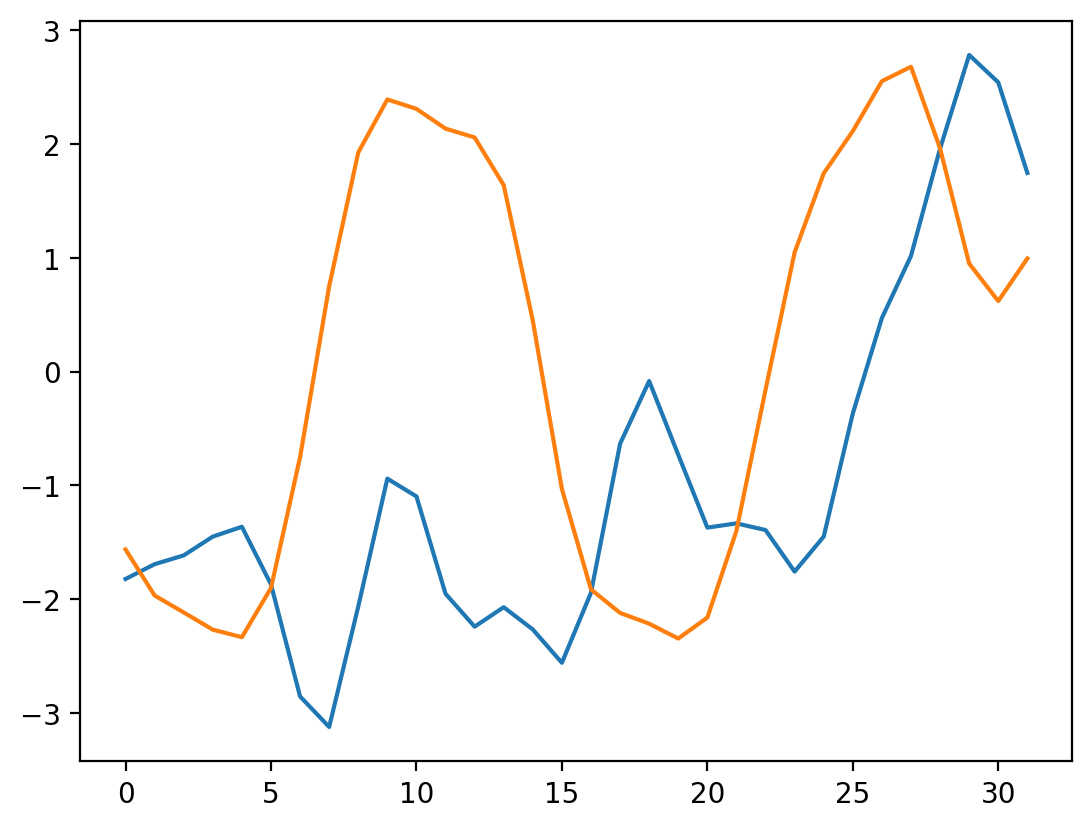

In [89]:
x, y = next(train_ds.as_numpy_iterator())
plt.plot(x[0][0])
plt.plot(x[0][1])

In [85]:
def FCN_model():
    inputs = layers.Input(shape=(2, None))
    
    # add channel dimension
    x = tf.expand_dims(inputs, axis=-1)
    
    # conv layers
    x = layers.Conv2D(filters=16, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(2, 4), strides=1, activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    # "fully connected" layers
    x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu")(x)
    # x = layers.Dropout(0.5)(x) # TODO: add batch norm?
    
    x = layers.Conv2D(filters=3, kernel_size=1, strides=1, activation=None)(x)
    pred = layers.GlobalAveragePooling2D()(x) # TODO: add dropout and batch norm?
    
    model = keras.Model(inputs=inputs, outputs=pred)
    print(model.summary())
    return model

In [86]:
model = FCN_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_ds, epochs=10, validation_data=validate_ds, validation_steps=None)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2, None)]         0         
                                                                 
 tf.expand_dims_18 (TFOpLam  (None, 2, None, 1)        0         
 bda)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 2, None, 16)       80        
                                                                 
 batch_normalization_52 (Ba  (None, 2, None, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_87 (Conv2D)          (None, 2, None, 64)       4160      
                                                                 
 batch_normalization_53 (Ba  (None, 2, None, 64)       256

In [87]:
for snr, ds in ds_per_snr.items():
    print(snr)
    # shuffle
    ds = ds.shuffle(buffer_size=ds.cardinality())
    # batch
    ds = ds.batch(batch_size, drop_remainder=True)
    model.evaluate(ds)
    print()

-10
93/93 [==============================] - 0s 957us/step - loss: 1.2235 - accuracy: 0.3621

-5
93/93 [==============================] - 0s 942us/step - loss: 1.0929 - accuracy: 0.4368

0
93/93 [==============================] - 0s 939us/step - loss: 0.7666 - accuracy: 0.6788

5
93/93 [==============================] - 0s 971us/step - loss: 0.3311 - accuracy: 0.9273

10
93/93 [==============================] - 0s 1ms/step - loss: 0.2033 - accuracy: 0.9567

15
93/93 [==============================] - 0s 968us/step - loss: 0.1994 - accuracy: 0.9565

20
93/93 [==============================] - 0s 947us/step - loss: 0.1982 - accuracy: 0.9603

25
93/93 [==============================] - 0s 985us/step - loss: 0.1997 - accuracy: 0.9563



In [58]:
model.evaluate(test_ds)

150/150 [==============================] - 0s 1ms/step - loss: 0.5579 - accuracy: 0.7695


[0.5578543543815613, 0.7694791555404663]

In [ ]:
# epochs = 6
# criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)

# for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")
#     for step, (inputs, labels) in enumerate(train_gen):
#         with tf.GradientTape() as tape:
#             logits = model(inputs, training=True)
#             loss = criterion(labels, logits)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         if not step % 500:
#             print(f"Training loss: {float(loss)}")